# Custom Training with YOLOv5

In this tutorial, we assemble a dataset and train a custom YOLOv5 model to recognize the objects in our dataset. To do so we will take the following steps:

* Gather a dataset of images and label our dataset
* Export our dataset to YOLOv5
* Train YOLOv5 to recognize the objects in our dataset
* Evaluate our YOLOv5 model's performance
* Run test inference to view our model at work



![](https://uploads-ssl.webflow.com/5f6bc60e665f54545a1e52a5/615627e5824c9c6195abfda9_computer-vision-cycle.png)

# 1. Install Requirements

In [2]:
# #clone YOLOv5 and
# !git clone  https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
# %pip install -qr requirements.txt # install dependencies
# %pip install -q roboflow

/home/data3t/daiboo/yolo_trace/yolov5


In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch

from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 2.3.1 (NVIDIA GeForce RTX 3090)


# 2. Preparing a custom dataset

Building a custom dataset can be a painful process. It might take dozens or even hundreds of hours to collect images, label them, and export them in the proper format. Fortunately, Roboflow makes this process as straightforward and fast as possible. Let me show you how!

### Step 1: Creating project

Before you start, you need to create a Roboflow [account](https://app.roboflow.com/login). Once you do that, you can create a new project in the Roboflow [dashboard](https://app.roboflow.com/). Keep in mind to choose the right project type. In our case, Object Detection.

<div align="center">
  <img
    width="640"
    src="https://media.roboflow.com/preparing-custom-dataset-example/creating-project.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1672929799852"
  >
</div>

### Step 2: Uploading images

Next, add the data to your newly created project. You can do it via API or through our [web interface](https://docs.roboflow.com/adding-data/object-detection).

If you drag and drop a directory with a dataset in a supported format, the Roboflow dashboard will automatically read the images and annotations together.

<div align="center">
  <img
    width="640"
    src="https://media.roboflow.com/preparing-custom-dataset-example/uploading-images.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1672929808290"
  >
</div>

### Step 3: Labeling

If you only have images, you can label them in [Roboflow Annotate](https://docs.roboflow.com/annotate).

<div align="center">
  <img
    width="640"
    src="https://user-images.githubusercontent.com/26109316/210901980-04861efd-dfc0-4a01-9373-13a36b5e1df4.gif"
  >
</div>

### Step 4: Generate new dataset version

Now that we have our images and annotations added, we can Generate a Dataset Version. When Generating a Version, you may elect to add preprocessing and augmentations. This step is completely optional, however, it can allow you to significantly improve the robustness of your model.

<div align="center">
  <img
    width="640"
    src="https://media.roboflow.com/preparing-custom-dataset-example/generate-new-version.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1673003597834"
  >
</div>

### Step 5: Exporting dataset

Once the dataset version is generated, we have a hosted dataset we can load directly into our notebook for easy training. Click `Export` and select the `YOLO v5 PyTorch` dataset format.

<div align="center">
  <img
    width="640"
    src="https://media.roboflow.com/preparing-custom-dataset-example/export.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1672943313709"
  >
</div>


### Step 6: Download a Dataset

Add your Roboflow API key below to download the default money counting dataset. Alternatively, use the code provided by the Roboflow dashboard in the above step to load a custom dataset.

#### 配置环境变量

In [4]:
os.environ["DATASET_DIRECTORY"] = "../datasets"
os.environ["HTTP_PROXY"] = "http://你的proxy ip:7890"
os.environ["HTTPS_PROXY"] = "http://你的proxy ip:7890"

#### 获取自定义数据集

In [5]:

# !!! 这个地方要粘贴你自己的获取数据集代码


loading Roboflow workspace...
loading Roboflow project...


In [6]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat {dataset.location}/data.yaml

names:
- box
- cup
- glue-stick
- phone
nc: 4
roboflow:
  license: CC BY 4.0
  project: yolo_trace_640_480_update
  url: https://universe.roboflow.com/yolotrace/yolo_trace_640_480_update/dataset/1
  version: 1
  workspace: yolotrace
test: ../test/images
train: ../datasets/yolo_trace_640_480_update-1/train/images
val: ../datasets/yolo_trace_640_480_update-1/valid/images


# 3. Define Model Configuration and Architecture

We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

You do not need to edit these cells, but you may.

In [7]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [8]:
#this is the model configuration we will use for our tutorial
%cat models/yolov5n.yaml

# Ultralytics YOLOv5 🚀, AGPL-3.0 license

# Parameters
nc: 80 # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.25 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4],

In [9]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [10]:
%%writetemplate ./models/yolov5_trace.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: {num_classes} # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.25  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]


# 4. Train Custom YOLOv5 Detector

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** Our dataset locaiton is saved in the `dataset.location`
- **weights:** specify a path to weights to start transfer learning from. Here we choose the generic COCO pretrained checkpoint.
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [10]:
# train yolov5s on custom data for 100 epochs
# time its performance
%time
!python train.py --img 640 --batch 16 --epochs 300 --data {dataset.location}/data.yaml --cfg ./models/yolov5_trace.yaml --weights yolov5n.pt  --cache --device 0

CPU times: user 2 µs, sys: 4 µs, total: 6 µs
Wall time: 11.4 µs
train: weights=yolov5n.pt, cfg=./models/yolov5_trace.yaml, data=/home/data3t/daiboo/yolo_trace/datasets/yolo_trace_640_480_update-1/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: skipping check (offline), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 v7.0-345-g8003649c Python-3.8.19 torch-2.3.1 CUDA:0 (NVIDIA GeForce R

# 5.Evaluate Custom YOLOv5 Detector Performance
Training losses and performance metrics are saved to Tensorboard and also to a logfile.

If you are new to these metrics, the one you want to focus on is `mAP_0.5` - learn more about mean average precision [here](https://blog.roboflow.com/mean-average-precision/).

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
#@title Select YOLOv5 🚀 logger {run: 'auto'}
# %load_ext tensorboard
# %tensorboard --logdir runs
# logger = 'TensorBoard' #@param ['TensorBoard', 'Comet', 'ClearML']

# if logger == 'TensorBoard':
#   %load_ext tensorboard
#   %tensorboard --logdir runs/train
# elif logger == 'Comet':
#   %pip install -q comet_ml
#   import comet_ml; comet_ml.init()
# elif logger == 'ClearML':
#   %pip install -q clearml
#   import clearml; clearml.browser_login()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
TensorFlow installation not found - running with reduced feature set.
I0000 00:00:1721468020.769142   66936 config.cc:230] gRPC experiments enabled: call_status_override_on_cancellation, event_engine_dns, event_engine_listener, http2_stats_fix, monitoring_experiment, pick_first_new, trace_record_callops, work_serializer_clears_time_cache
I0000 00:00:1721468020.773496   67150 subchannel.cc:806] subchannel 0x384e5f0 {address=ipv6:%5B::1%5D:37925, args={grpc.client_channel_factory=0x2e6d430, grpc.default_authority=localhost:37925, grpc.internal.channel_credentials=0x2e6c7f0, grpc.internal.client_channel_call_destination=0x7f7c7fb103d0, grpc.internal.event_engine=0x3135360, grpc.internal.security_connector=0x347cdb0, grpc.internal.subchannel_pool=0x2ea2370, grpc.max_receive_message_length=268435456, grpc.primary_user_agent=grpc-python/1.65.1, grpc.resource_quota=0x3563ab0, grpc.server_uri=dns:///localhost:37925}}: con

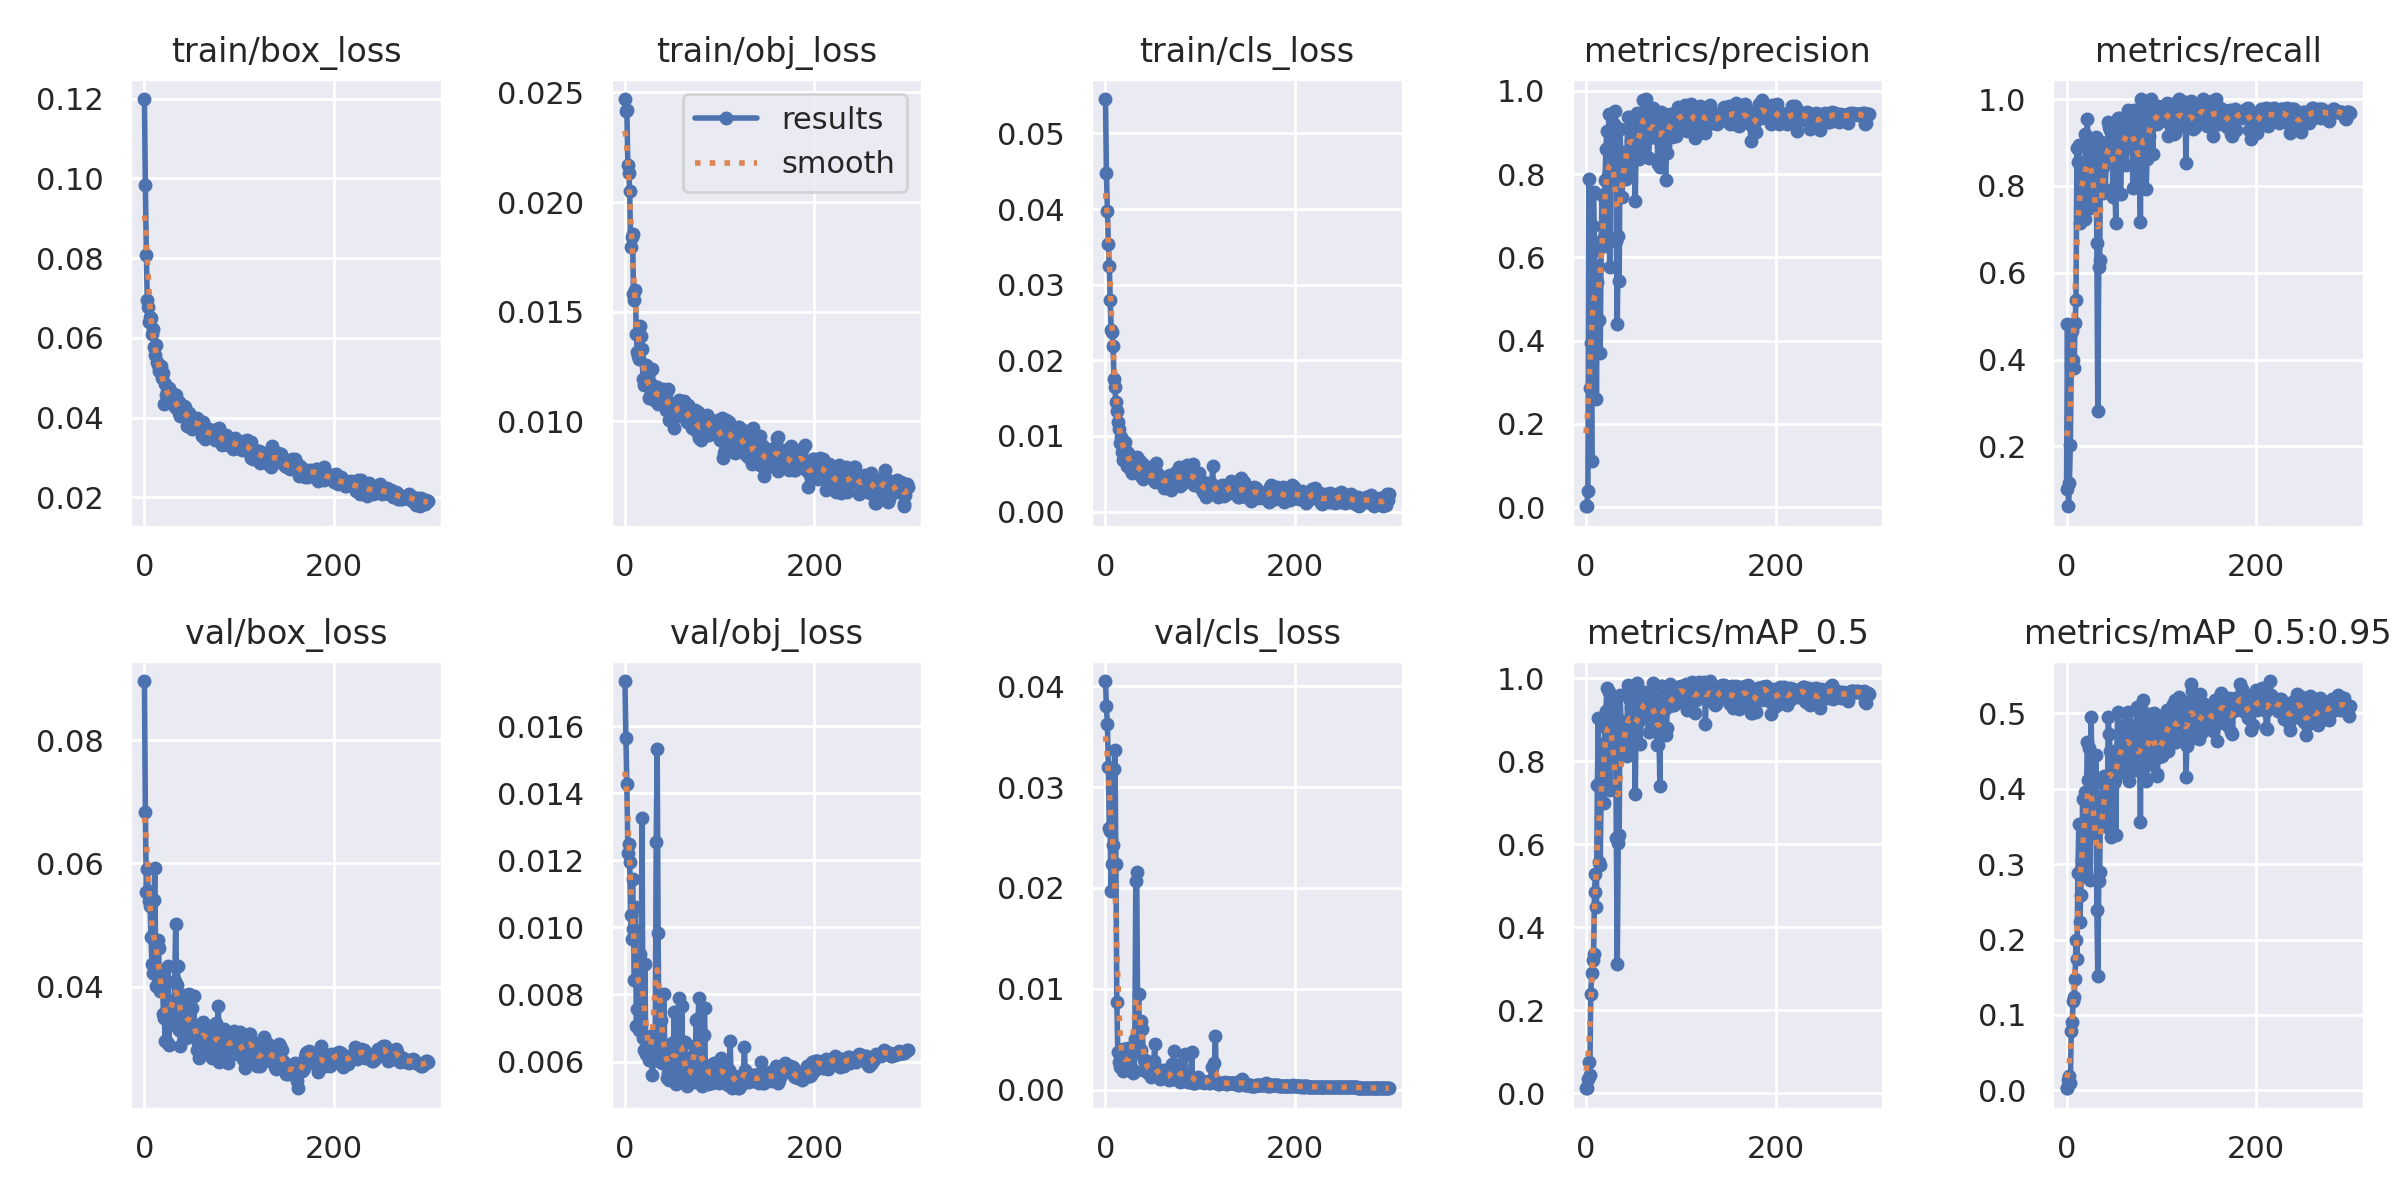

In [11]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='runs/train/exp7/results.png', width=1000)  # view results.png

### Curious? Visualize Our Training Data with Labels

After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

In [ ]:
Image(filename='runs/train/exp7/val_batch0_labels.jpg', width=900)

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='runs/train/exp7/train_batch1.jpg', width=900)

# 6.Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [14]:
!python detect.py --weights runs/train/exp7/weights/best.pt --img 680 --conf 0.3 --source {dataset.location}/test/images

detect: weights=['runs/train/exp7/weights/best.pt'], source=/home/data3t/daiboo/yolo_trace/datasets/yolo_trace_640_480_update-1/test/images, data=data/coco128.yaml, imgsz=[680, 680], conf_thres=0.3, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-345-g8003649c Python-3.8.19 torch-2.3.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24049MiB)

Fusing layers... 
YOLOv5_trace summary: 157 layers, 1764577 parameters, 0 gradients, 4.1 GFLOPs
WARNING ⚠️ --img-size [680, 680] must be multiple of max stride 32, updating to [704, 704]
image 1/31 /home/data3t/daiboo/yolo_trace/datasets/yolo_trace_640_480_update-1/test/images/captured_frame_100_jpg.rf.14332fdb75517d56c70d4d728c7d1576.jpg: 704x704 1